Guia de como ejecutar:
1-Ejecutar los imports primero
2-Todo lo que esta antes de "Subset de todas las lineas para los graficos de presentacion" es para formatear el dataset del gobierno y separar la linea D
3-Todo lo que esta despues de "Subset de todas las lineas para los graficos de presentacion" es para sacar los graficos para la presentacion
4-Para ejecutar la parte de los issues van a necesitar el dataset "Twittermetrovias.csv" que esta subido en git
5-Para los graficos de plotly fijense en este link para configurar, yo en windows no pude encontrar el file que es necesario modificar
https://plot.ly/python/getting-started/

In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.plotly as ply
import plotly.graph_objs as go
from datetime import datetime
import numpy as np
pd.set_option('float_format', '{:,f}'.format)

Levantar el archivo de molinetes 2018, formatearlo y guardar solo la linea D ( se puede elegir que linea guardar)

In [ ]:

mol_2018 = pd.read_csv(r'C:\Users\javier.gamboa\Desktop\Final-Project-EANT-master\Mol_2018.csv', sep=",")

mol_2018.columns = map(str.upper, mol_2018.columns)
mol_2018['FECHA'] = pd.to_datetime(mol_2018['FECHA'])
mol_2018['Month'] = pd.DatetimeIndex(mol_2018['FECHA']).month
mol_2018['Year'] = pd.DatetimeIndex(mol_2018['FECHA']).year

mol_2018.drop(['PAX_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_PASES_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_FRANQ'],axis=1,inplace=True)

mol_2018['TOTAL'].fillna(0, inplace=True)
mol_2018.dropna(how='any', inplace=True)
mol_2018=mol_2018[mol_2018['MOLINETE'].apply(lambda x: "LINEA_D" in x )]


mol_2018.to_csv("Linea_D_sintwitt.csv", sep=';', encoding='utf-8')

Abrir el csv una vez guardado (si se corre antes el codigo de arriba y queda el df en la variable mol_2018 usar ese en vez de LIND, obviamente reemplazando LIND por mol_2018), formatearlo y juntar el del twitter

In [ ]:
LIND = pd.read_csv(r'C:\Users\javier.gamboa\Desktop\Final-Project-EANT-master\Final-Project-EANT-master\Final-Project-EANT-master\Notebooks\Linea_D_sintwitt.csv', sep=";")

LIND['FECHA'] = pd.to_datetime(pd.Series(LIND['FECHA']), format="%Y/%m/%d")
LIND['DESDE'] =pd.to_datetime(pd.Series(LIND['DESDE']), format='%H:%M:%S')

#esto es para filtrar
#LIND[LIND['DESDE'] > datetime.strptime("08:00:00",'%X')]


TWD = pd.read_csv(r'C:\Users\alejandro.m.gizzi\Documents\Mine\TweetA.csv', sep=";")

TWD['DATE'] = pd.to_datetime(pd.Series(TWD['DATE']), format="%Y/%m/%d")
TWD['TIME'] =pd.to_datetime(pd.Series(TWD['TIME']), format='%H:%M:%S')

TWD.rename(columns={'DATE': 'FECHA'}, inplace=True)

#TWD.drop(['Unnamed: 0'],axis=1,inplace=True)
TWD.drop(['Linea D'],axis=1,inplace=True)
TWD.drop(['Demora'],axis=1,inplace=True)
TWD.drop(['Sinterrumpido'],axis=1,inplace=True)
TWD.drop(['Snormal'],axis=1,inplace=True)
TWD.drop(['Slimitado'],axis=1,inplace=True)
TWD.drop(['SdemFG'],axis=1,inplace=True)

TWD['Issuetype']=TWD['TEXT'].apply(lambda x: 'demora' if 'demora' in x else 'interrumpido' if 'interrumpido' in x else 'Normal' if 'frecuencia normal' in x else 'limitado' if 'limitado' in x else 'Normal')


def standdate(timestr):
    if (timestr.minute < 15 and timestr.minute >= 00):
        ab =(str('{:02d}'.format(timestr.hour)) + ":00:00")
    elif (timestr.minute >= 15 and timestr.minute < 30):
        ab =(str('{:02d}'.format(timestr.hour)) + ":15:00")
    elif (timestr.minute >= 30):
        ab = (str('{:02d}'.format(timestr.hour)) + ":30:00")

    return ab


TWD['DESDE'] = TWD['TIME'].map(standdate)
TWD['DESDE'] =pd.to_datetime(pd.Series(TWD['DESDE']), format='%H:%M:%S')

LINDTWD = pd.merge(LIND,TWD,how='left',on=['FECHA','DESDE'])

LINDTWD['WeekDay'] = LINDTWD['FECHA'].dt.strftime("%A")

#agrega el mean
BMOLmean= LINDTWD.groupby(['ESTACION','WeekDay','DESDE'], as_index=False)['TOTAL'].mean()
BMOLmean.rename(columns={'TOTAL': 'Mean'}, inplace=True)
LINDTWDmean = pd.merge(LINDTWD,BMOLmean,how='left',on=['ESTACION','WeekDay','DESDE'])


LINDTWDmean.to_csv("LineaDcontwit.csv", sep=';', encoding='utf-8')



In [57]:
TWD.head()

NameError: name 'TWD' is not defined

GRAFICOS (levantar LineaDcontwit.csv)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

from matplotlib.ticker import MaxNLocator
from collections import namedtuple



Total por mes

In [ ]:
TotPag18 = LINDTWDmean
TotPag18.set_index(["Month"], inplace=True)
TotPag18 = TotPag18.sum(level=["Month"])

TotPag18 = TotPag18.reset_index()


fig, ax = plt.subplots(figsize=(25,10))
ax.plot(TotPag18['Month'], TotPag18['TOTAL'], color='r')
plt.show()


Por dia

In [ ]:
LINDTWDmean = LINDTWDmean.reset_index()
TotPag18 = LINDTWDmean
TotPag18.set_index(["FECHA"], inplace=True)
TotPag18 = TotPag18.sum(level=["FECHA"])

TotPag18 = TotPag18.reset_index()

TotPag18= TotPag18.sort_values(by='FECHA')


#years = mdates.YearLocator()   # every year
#months = mdates.MonthLocator()  # every month
#yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots(figsize=(50,5))
ax.plot(TotPag18['FECHA'], TotPag18['TOTAL'])


ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

Por Estacion

In [ ]:
LINDTWDmean = LINDTWDmean.reset_index()
TotPag18 = LINDTWDmean
TotPag18.set_index(["ESTACION"], inplace=True)
TotPag18 = TotPag18.sum(level=["ESTACION"])

TotPag18 = TotPag18.reset_index()

#TotPag18= TotPag18.sort_values(by='FECHA')



GRAFICO PIE

In [ ]:
# Pie chart solo 
labels = TotPag18.ESTACION
sizes = TotPag18.TOTAL
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')



fig, axs = plt.subplots(figsize=(30,10))
axs.pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)                     


#fig.tight_layout()

plt.show()

                            
                 

GRAFICO DE BARRAS

In [ ]:
#BAR SOLO
#https://webcache.googleusercontent.com/search?q=cache:WY7G0y4OxQ8J:https://stackoverflow.com/questions/43560801/display-y-axis-value-horizontal-line-drawn-in-bar-chart+&cd=4&hl=es-419&ct=clnk&gl=ar
import matplotlib.colors
fig, ax = plt.subplots(figsize=(25,10))

index = np.arange(TotPag18.ESTACION.count())

bar_width = 0.35
opacity = 0.4

norm = matplotlib.colors.Normalize(30e3, 60e3)
ax.bar(index,TotPag18.TOTAL, bar_width,alpha=opacity,
       color=np.random.rand ( 256,3),
       label='ESTACION')


#rects1 = ax.bar(index, TotPag18.TOTAL, bar_width,
#                alpha=opacity, color='b',
#                label='ESTACION')

#rects2 = ax.bar(index + bar_width, means_women, bar_width,
#                alpha=opacity, color='r',
#                yerr=std_women, error_kw=error_config,
#                label='Women')

#ax.set_xlabel('Group')
#ax.set_ylabel('Scores')
#ax.set_title('Scores by group and gender')
ax.axhline(TotPag18.TOTAL.mean(), color="gray")
ax.grid(True)
ax.text(1.02, TotPag18.TOTAL.mean(), "Mean: " + str(TotPag18.TOTAL.mean()),transform=ax.get_yaxis_transform())
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(TotPag18.ESTACION)
ax.legend()

fig.tight_layout()
plt.show()

BARRAS Y PIE

In [ ]:
# Pie chart
labels = TotPag18.ESTACION
sizes = TotPag18.TOTAL
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

#bar chart
index = np.arange(TotPag18.ESTACION.count())
bar_width = 0.35
opacity = 0.4



fig, axs = plt.subplots(2, 1, figsize=(30,10))
axs[0].pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)                     
axs[1].bar(index, TotPag18.TOTAL, bar_width,
                alpha=opacity, color='b',
                label='Estacion')
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels(TotPag18.ESTACION)
axs[1].legend()


#fig.tight_layout()

plt.show()

                            
                 

In [ ]:

#limpiar las estaciones que estan mal
#LINDTWD['ESTACION']=LINDTWD['ESTACION'].apply(lambda x: 'Aguero' if 'Agüero' in x else x)
#LINDTWD.ESTACION.unique()


In [ ]:
#esto es otro subset que hice para probar algo, no es necesario correrlo
mol_2018 = pd.read_csv(r'C:\Users\alejandro.m.gizzi\Documents\Mine\Mol 2018.csv', sep=",")
mol_2018.columns = map(str.upper, mol_2018.columns)
mol_2018['FECHA'] = pd.to_datetime(mol_2018['FECHA'])
mol_2018['Month'] = pd.DatetimeIndex(mol_2018['FECHA']).month
mol_2018.drop(['PAX_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_PASES_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_FRANQ'],axis=1,inplace=True)

mol_2018 = mol_2018[mol_2018.MOLINETE.apply(lambda x: 'LineaD' in x)]


#mol_2018['TOTAL'].fillna(0, inplace=True)


mol_2018.dropna(how='any', inplace=True)
mol_2018.to_csv("Linea_D_sintwitt2.csv", sep=';', encoding='utf-8')



PLOTLY GRAFICOS (MAS DINAMICOS)

Configuracion plotly


In [ ]:
import sys
import plotly 
import plotly.plotly as py
import json
import requests
from requests.auth import HTTPBasicAuth


username = 'alekido' # Replace with YOUR USERNAME
api_key = 'JPkecUvguXvx2Kwehb8G' # Replace with YOUR API KEY

plotly.tools.set_credentials_file(username=username, api_key=api_key)



auth = HTTPBasicAuth(username, api_key)
headers = {'Plotly-Client-Platform': 'python'}
plotly.tools.set_credentials_file(username=username, api_key=api_key)
def get_pages(username, page_size):
    url = 'https://api.plot.ly/v2/folders/all?user='+username+'&page_size='+str(page_size)
    response = requests.get(url, auth=auth, headers=headers)
    if response.status_code != 200:
        return
    page = json.loads(response.content)
    yield page
    while True:
        resource = page['children']['next'] 
        if not resource:
            break
        response = requests.get(resource, auth=auth, headers=headers)
        if response.status_code != 200:
            break
        page = json.loads(response.content)
        yield page
        

def permanently_delete_files(username, page_size=500, filetype_to_delete='plot'):
    for page in get_pages(username, page_size):
        for x in range(0, len(page['children']['results'])):
            fid = page['children']['results'][x]['fid']
            res = requests.get('https://api.plot.ly/v2/files/' + fid, auth=auth, headers=headers)
            res.raise_for_status()
            if res.status_code == 200:
                json_res = json.loads(res.content)
                if json_res['filetype'] == filetype_to_delete:
                    # move to trash
                    requests.post('https://api.plot.ly/v2/files/'+fid+'/trash', auth=auth, headers=headers)
                    # permanently delete
                    requests.delete('https://api.plot.ly/v2/files/'+fid+'/permanent_delete', auth=auth, headers=headers)

                    
                    
                    
                    
permanently_delete_files('alekido', filetype_to_delete='plot')
permanently_delete_files('alekido', filetype_to_delete='grid')

Graficos

In [7]:
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go
import pandas as pd
from datetime import datetime
from plotly import tools

Dos plots uno mixeado

In [ ]:

#df = pd.read_csv('C:\Users\alejandro.m.gizzi\Documents\Mine\LineaDcontwit.csv', sep=";")
#cambiar la ruta de donde esta el archivo
#df = pd.read_csv('/home/ale/Documents/TP FINAL/Areadytoplot.csv', sep=";")
#df['FECHA'] = pd.to_datetime(df['FECHA'])
#df['ESTACION'] = df['ESTACION'].astype('str')
#df['DESDE'] = pd.to_datetime(pd.Series(df['DESDE']), format='%H:%M:%S')

#jueguen con esto para ir filtrando el dataset
sdf = df[(df['ESTACION'] =='Catedral') &  (df['FECHA'] =='2018-04-01')]

#https://stackoverflow.com/questions/51181729/custom-plotly-markers-based-on-variable-value
def SetColor(x):
    if(x !='Normal'):
        return "red"
    else:
        return "green"

def Setsize(x):
    if(x !='Normal'):
        return 40
    else:
        return 5
    
#https://plot.ly/python/figure-labels/
#https://plot.ly/python/offline/
data1 = go.Scatter(x=sdf.DESDE,y=sdf['TOTAL'],mode ='lines+markers',
                   name="Total horario",
                   text=sdf['TEXT'],
                   marker = dict(color=list(map(SetColor, sdf['Issuetype'])),
                                size=list(map(Setsize, sdf['Issuetype']))))


data2 = go.Scatter(x=sdf.DESDE,y=sdf['MEAN'].apply(np.round),name="MEAN")

fig = tools.make_subplots(rows=1, cols=2)

fig.append_trace(data1, 1, 1)
fig.append_trace(data2, 1, 2)



py.iplot(fig)

Mas de un plot

In [ ]:
sdf = df[(df['MOLINETE'] =='LINEA_A_CBARROS_S_TURN01') & (df['FECHA'] =='2018-08-01')]
sdf2 = df[(df['MOLINETE'] =='LINEA_A_LIMA_S_TURN03') & (df['FECHA'] =='2018-08-01')]
sdf3 = df[(df['MOLINETE'] =='LINEA_A_SANPEDRITO_ESTE_TURN04') & (df['FECHA'] =='2018-08-01')]
sdf4 = df[(df['MOLINETE'] =='LINEA_A_ACOYTE_N_TURN05') & (df['FECHA'] =='2018-08-01')]
sdf5 = df[(df['MOLINETE'] =='LINEA_A_PJUNTA_S_TURN02') & (df['FECHA'] =='2018-08-01')]

#https://stackoverflow.com/questions/51181729/custom-plotly-markers-based-on-variable-value
def SetColor(x):
    if(x !='Normal'):
        return "red"
    else:
        return "green"

def Setsize(x):
    if(x !='Normal'):
        return 40
    else:
        return 5
    
#https://plot.ly/python/figure-labels/
#https://plot.ly/python/offline/
data1 = go.Scatter(x=sdf.DESDE,y=sdf['TOTAL'],mode ='lines+markers',
                   name="MOL1",
                   text=sdf['TEXT'],
                   marker = dict(color=list(map(SetColor, sdf['Issuetype'])),
                                size=list(map(Setsize, sdf['Issuetype']))))




data2 = go.Scatter(x=sdf2.DESDE,y=sdf2['TOTAL'].apply(np.round),name="MOL2")
data3 = go.Scatter(x=sdf3.DESDE,y=sdf3['TOTAL'].apply(np.round),name="MOL3")
data4 = go.Scatter(x=sdf4.DESDE,y=sdf4['TOTAL'].apply(np.round),name="MOL4")
data5 = go.Scatter(x=sdf5.DESDE,y=sdf5['TOTAL'].apply(np.round),name="MOL5")

fig = tools.make_subplots(rows=3, cols=2)

fig.append_trace(data1, 1, 1)
fig.append_trace(data2, 1, 2)
fig.append_trace(data3, 2, 1)
fig.append_trace(data4, 2, 2)
fig.append_trace(data5, 3, 1)



py.iplot(fig)

In [ ]:
#dataframe con totales de estacion y molinete de la linea D
df['Issue'] = df.Issuetype.apply(lambda x: 0 if x == 'Normal' else 1)
dftot=df.groupby(['ESTACION','MOLINETE'], as_index=False)['TOTAL'].sum()
dfdfis=df.groupby(['ESTACION','MOLINETE'], as_index=False)['Issue'].sum()

dfnew = pd.merge(dftot,dfdfis,how='left',on=['ESTACION','MOLINETE'])
dfnew

Subset de todas las lineas para los graficos de presentacion

In [3]:
mol_2018 = pd.read_csv(r'C:\Users\javier.gamboa\Desktop\Final-Project-EANT-master\Mol_2018.csv', sep=",")

mol_2018.columns = map(str.upper, mol_2018.columns)
mol_2018['FECHA'] = pd.to_datetime(mol_2018['FECHA'])
mol_2018['Month'] = pd.DatetimeIndex(mol_2018['FECHA']).month
mol_2018['Year'] = pd.DatetimeIndex(mol_2018['FECHA']).year

mol_2018.drop(['PAX_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_PASES_PAGOS'],axis=1,inplace=True)
mol_2018.drop(['PAX_FRANQ'],axis=1,inplace=True)

mol_2018['TOTAL'].fillna(0, inplace=True)
mol_2018.dropna(how='any', inplace=True)

malestag=['AgÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â¼ero',
       'AgÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â¼ero',
       'AgÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â¼ero',
       'AgÃ\x83Â\x83Ã\x82Â¼ero','AgÃ\x83Â¼ero','AgÃ¼ero', 'Agüero']

mol_2018['ESTACION'] = mol_2018.ESTACION.apply(lambda x: 'AGUERO' if x in malestag else x)


malestsp = ['SAENZ PEÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x91A',
           'Saenz PeÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x82Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â±a ',
           'Saenz PeÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â\x83Ã\x83Â\x83Ã\x82Â\x82Ã\x83Â\x82Ã\x82Â±a ',
           'Saenz PeÃ\x83Â\x83Ã\x82Â\x83Ã\x83Â\x82Ã\x82Â±a ',
           'Saenz PeÃ\x83Â\x83Ã\x82Â±a ','Saenz PeÃ\x83Â±a ','Saenz PeÃ±a ', 'Saenz Peña ']
mol_2018['ESTACION'] = mol_2018.ESTACION.apply(lambda x: 'Saenz Pena' if x in malestsp else x)


mol_2018['LINEA'][mol_2018['LINEA'] =='LineaA'] = "LINEA_A"
mol_2018['LINEA'][mol_2018['LINEA'] =='LineaB'] = "LINEA_B"
mol_2018['LINEA'][mol_2018['LINEA'] =='LineaC'] = "LINEA_C"
mol_2018['LINEA'][mol_2018['LINEA'] =='LineaD'] = "LINEA_D"
mol_2018['LINEA'][mol_2018['LINEA'] =='LineaE'] = "LINEA_E"
mol_2018['LINEA'][mol_2018['LINEA'] =='LineaH'] = "LINEA_H"


mol_2018.to_csv("Todaslineas.csv", sep=';', encoding='utf-8')


#atot=mol_2018.groupby(['ESTACION','MOLINETE','FECHA'], as_index=False)['TOTAL'].sum()
#atot

C:\Users\javier.gamboa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\javier.gamboa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\javier.gamboa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\javier.gamboa\AppData\Local\Continuum\an

Pie con totales por linea

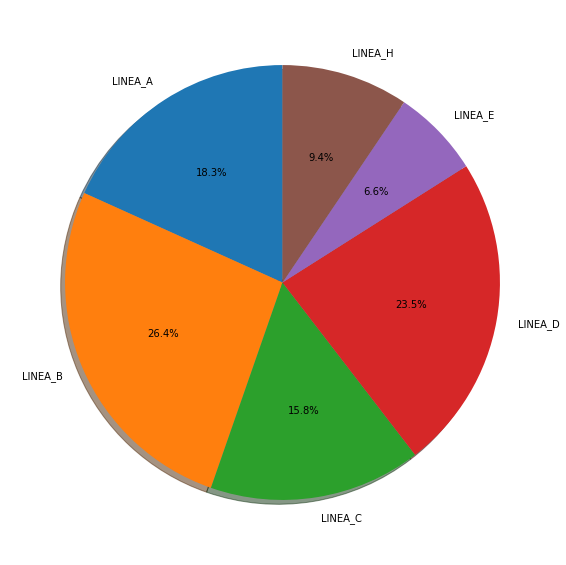

In [4]:
totlinea=mol_2018.groupby('LINEA', as_index=False)['TOTAL'].sum()


labels = totlinea.LINEA
sizes = totlinea.TOTAL

fig, axs = plt.subplots(figsize=(30,10))
axs.pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)                     

plt.show()


BARRA Y PIE con totales por linea

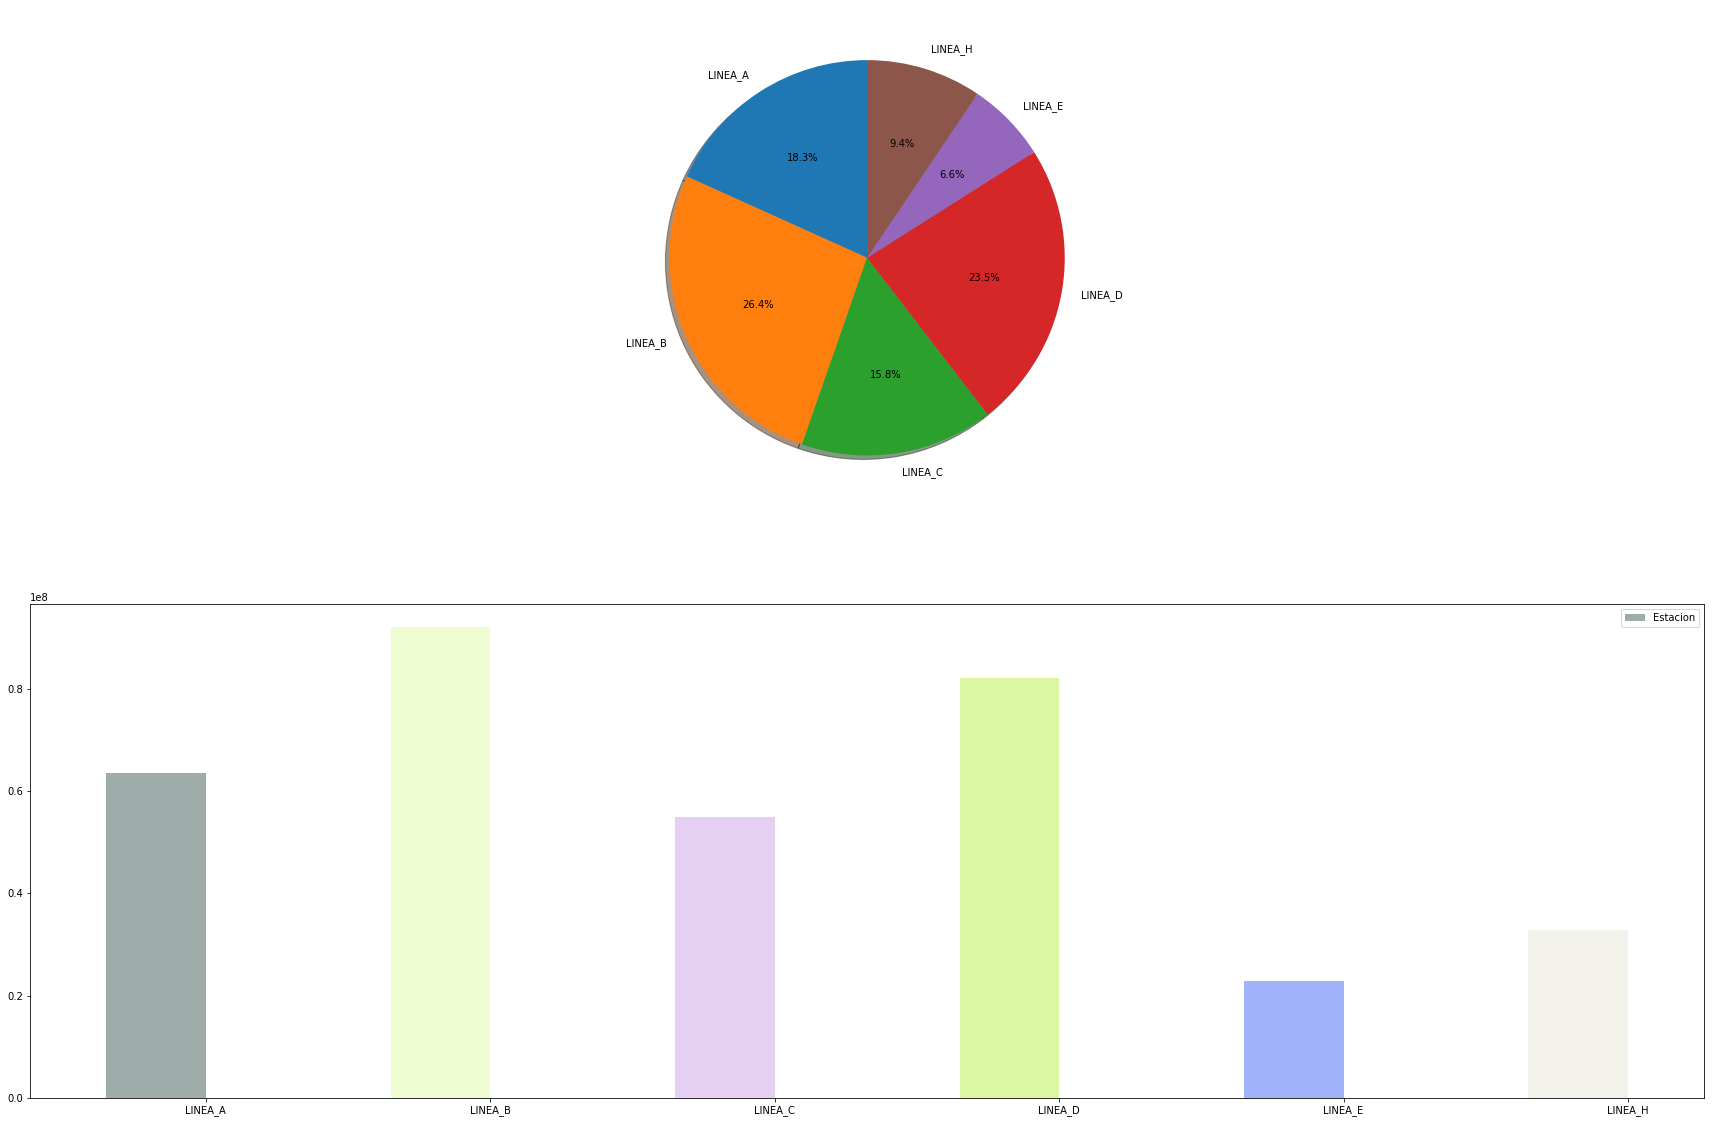

In [5]:
labels = totlinea.LINEA
sizes = totlinea.TOTAL
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

#bar chart
index = np.arange(totlinea.LINEA.count())
bar_width = 0.35
opacity = 0.4



fig, axs = plt.subplots(2, 1, figsize=(30,20))
axs[0].pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)                     
axs[1].bar(index, totlinea.TOTAL, bar_width,
                alpha=opacity, color=np.random.rand ( 256,3),
                label='Estacion')
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels(totlinea.LINEA)
axs[1].legend()


#fig.tight_layout()

plt.show()


Grafico LINEAL con totales por linea

In [59]:
totlineames=mol_2018.groupby(['LINEA','Month'], as_index=False)['TOTAL'].sum()

totlineaA=totlineames[totlineames.LINEA=='LINEA_A']
totlineaB=totlineames[totlineames.LINEA=='LINEA_B']
totlineaC=totlineames[totlineames.LINEA=='LINEA_C']
totlineaD=totlineames[totlineames.LINEA=='LINEA_D']
totlineaE=totlineames[totlineames.LINEA=='LINEA_E']
totlineaH=totlineames[totlineames.LINEA=='LINEA_H']

data1 = [go.Scatter(x=totlineaA.Month,y=totlineaA.TOTAL,mode ='lines+markers',
                   name="LineaA",
                   text=""),
         go.Scatter(x=totlineaB.Month,y=totlineaB.TOTAL,mode ='lines+markers',
                   name="LineaB",
                   text=""),
         go.Scatter(x=totlineaC.Month,y=totlineaC.TOTAL,mode ='lines+markers',
                   name="LineaC",
                   text=""),
         go.Scatter(x=totlineaD.Month,y=totlineaD.TOTAL,mode ='lines+markers',
                   name="LineaD",
                   text=""),
         go.Scatter(x=totlineaE.Month,y=totlineaE.TOTAL,mode ='lines+markers',
                   name="LineaE",
                   text=""),
         go.Scatter(x=totlineaH.Month,y=totlineaH.TOTAL,mode ='lines+markers',
                   name="LineaH",
                   text="")]


#data2 = go.Scatter(x=sdf.DESDE,y=sdf['MEAN'].apply(np.round),name="MEAN")

layout = dict(title = 'Total pasajeros por mes 2018',
              xaxis = dict(title = 'Mes',dtick=1),
              yaxis = dict(title = 'Cantidad pasajeros(millones)')
              )

fig = dict(data=data1,layout=layout)


py.iplot(fig)

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

In [40]:
proporcion = pd.merge(totlineames,twitttot,how='left',on=['LINEA','Month'])
proporcion['TOTAL']= proporcion['TOTAL']/1000
proporcion['eventos'] = proporcion['Issuetype']/proporcion['TOTAL']
proporcion

,LINEA,Month,TOTAL,Issuetype,eventos
0,LINEA_A,1,"4,242.957000",8.000000,0.001885
1,LINEA_A,2,"4,100.707000",8.000000,0.001951
2,LINEA_A,3,"5,053.053000",2.000000,0.000396
3,LINEA_A,4,"6,937.448000",3.000000,0.000432
4,LINEA_A,5,"5,257.176000",18.000000,0.003424
5,LINEA_A,6,"5,209.075000",7.000000,0.001344
6,LINEA_A,7,"6,964.506000",49.000000,0.007036
7,LINEA_A,8,"5,479.790000",45.000000,0.008212
8,LINEA_A,9,"6,655.560000",44.000000,0.006611
9,LINEA_A,10,"5,035.836000",53.000000,0.010525


In [56]:
twitttot.head()

,LINEA,Month,Issuetype
0,LINEA_A,1,8
1,LINEA_A,2,8
2,LINEA_A,3,2
3,LINEA_A,4,3
4,LINEA_A,5,18


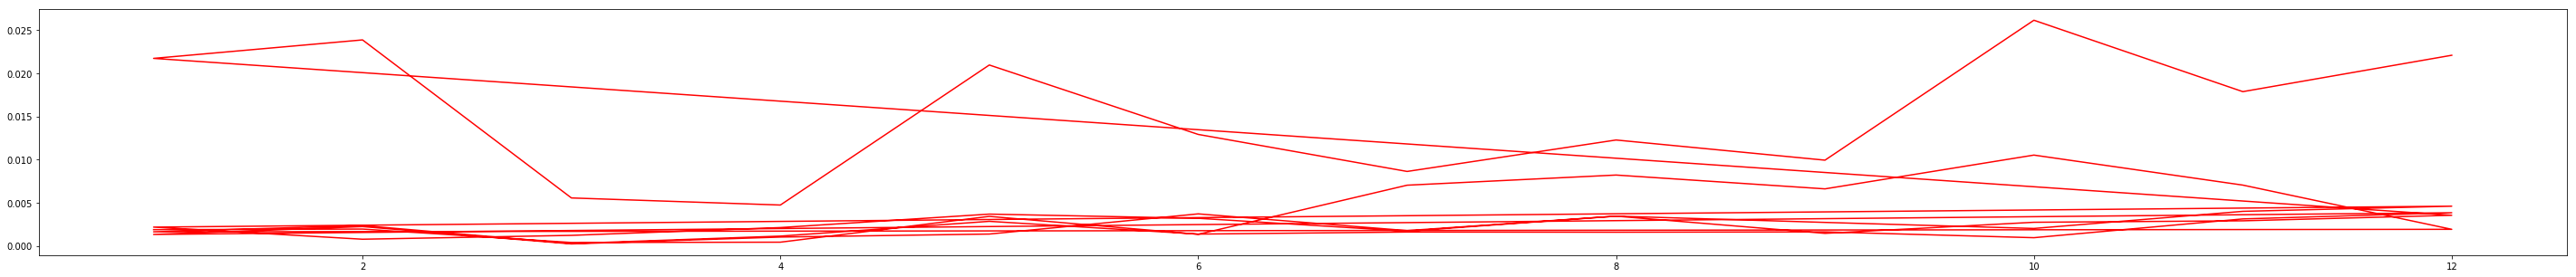

In [44]:
#line plot
fig, ax = plt.subplots(figsize=(50,5))
ax.plot(proporcion.Month, proporcion.eventos, color='r')
plt.show()

In [48]:
months = mdates.MonthLocator(proporcion.Month)  # every month


In [50]:
ax.xaxis.set_major_locator(months)


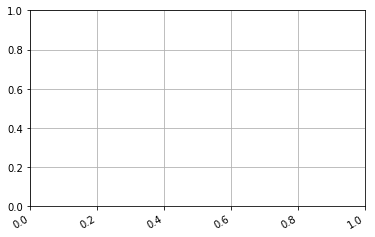

In [55]:
# format the coords message box
fig, ax = plt.subplots()
ax.format_xdata = mdates.DateFormatter(months)
ax.format_ydata = eventos
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.show()

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

Problemas de las lineas ( con dataset de twitter)

In [12]:
twitt = pd.read_csv(r"C:\Users\javier.gamboa\Desktop\Final-Project-EANT-master\Final-Project-EANT-master\Final-Project-EANT-master\Notebooks\Twittermetrovias.csv", sep=";")
twitt['Issuetype']=twitt['Issuetype'].apply(lambda x: 0 if 'Normal' in x else 1)
twitt['Month']= pd.DatetimeIndex(twitt['DATE']).month



In [58]:
twitt.head()

,Unnamed: 0,DATE,TEXT,Datestamp,TIME,WeekDay,Issuetype,LINEA,Month
0,0,2019-03-11,#LíneaD - Ya circula con su frecuencia normal....,2019-03-11 20:36:37,20:36:37,Monday,0,LINEA_D,3
1,1,2019-03-11,#LíneaD - Servicio con demora. 17:34,2019-03-11 20:34:36,20:34:36,Monday,1,LINEA_D,3
2,2,2019-03-11,#LíneaD - Ya realiza su recorrido completo ent...,2019-03-11 20:31:35,20:31:35,Monday,0,LINEA_D,3
3,3,2019-03-11,#LíneaD - Servicio limitado entre las estacion...,2019-03-11 18:54:34,18:54:34,Monday,1,LINEA_D,3
4,5,2019-03-11,#LíneaB - Ya circula con su frecuencia normal....,2019-03-11 16:37:31,16:37:31,Monday,0,LINEA_B,3


PIE PROBLEMAS LINEAS

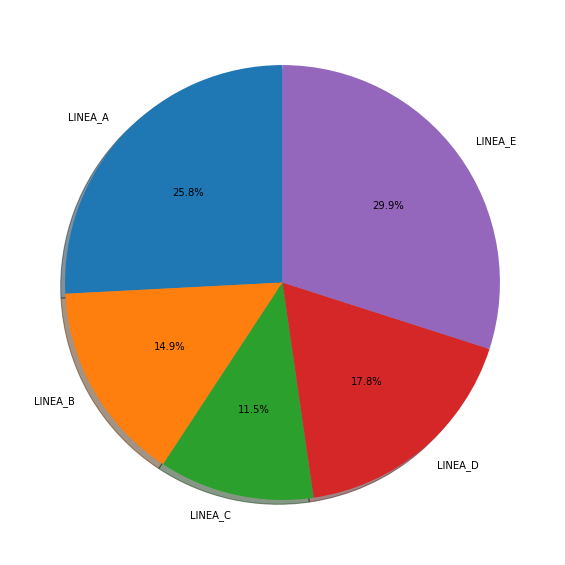

In [13]:
twitttot=twitt.groupby('LINEA', as_index=False)['Issuetype'].sum()


labels = twitttot.LINEA
sizes = twitttot.Issuetype

fig, axs = plt.subplots(figsize=(30,10))
axs.pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)                     

plt.show()


In [ ]:
BARRA Y PIE con problemas por linea

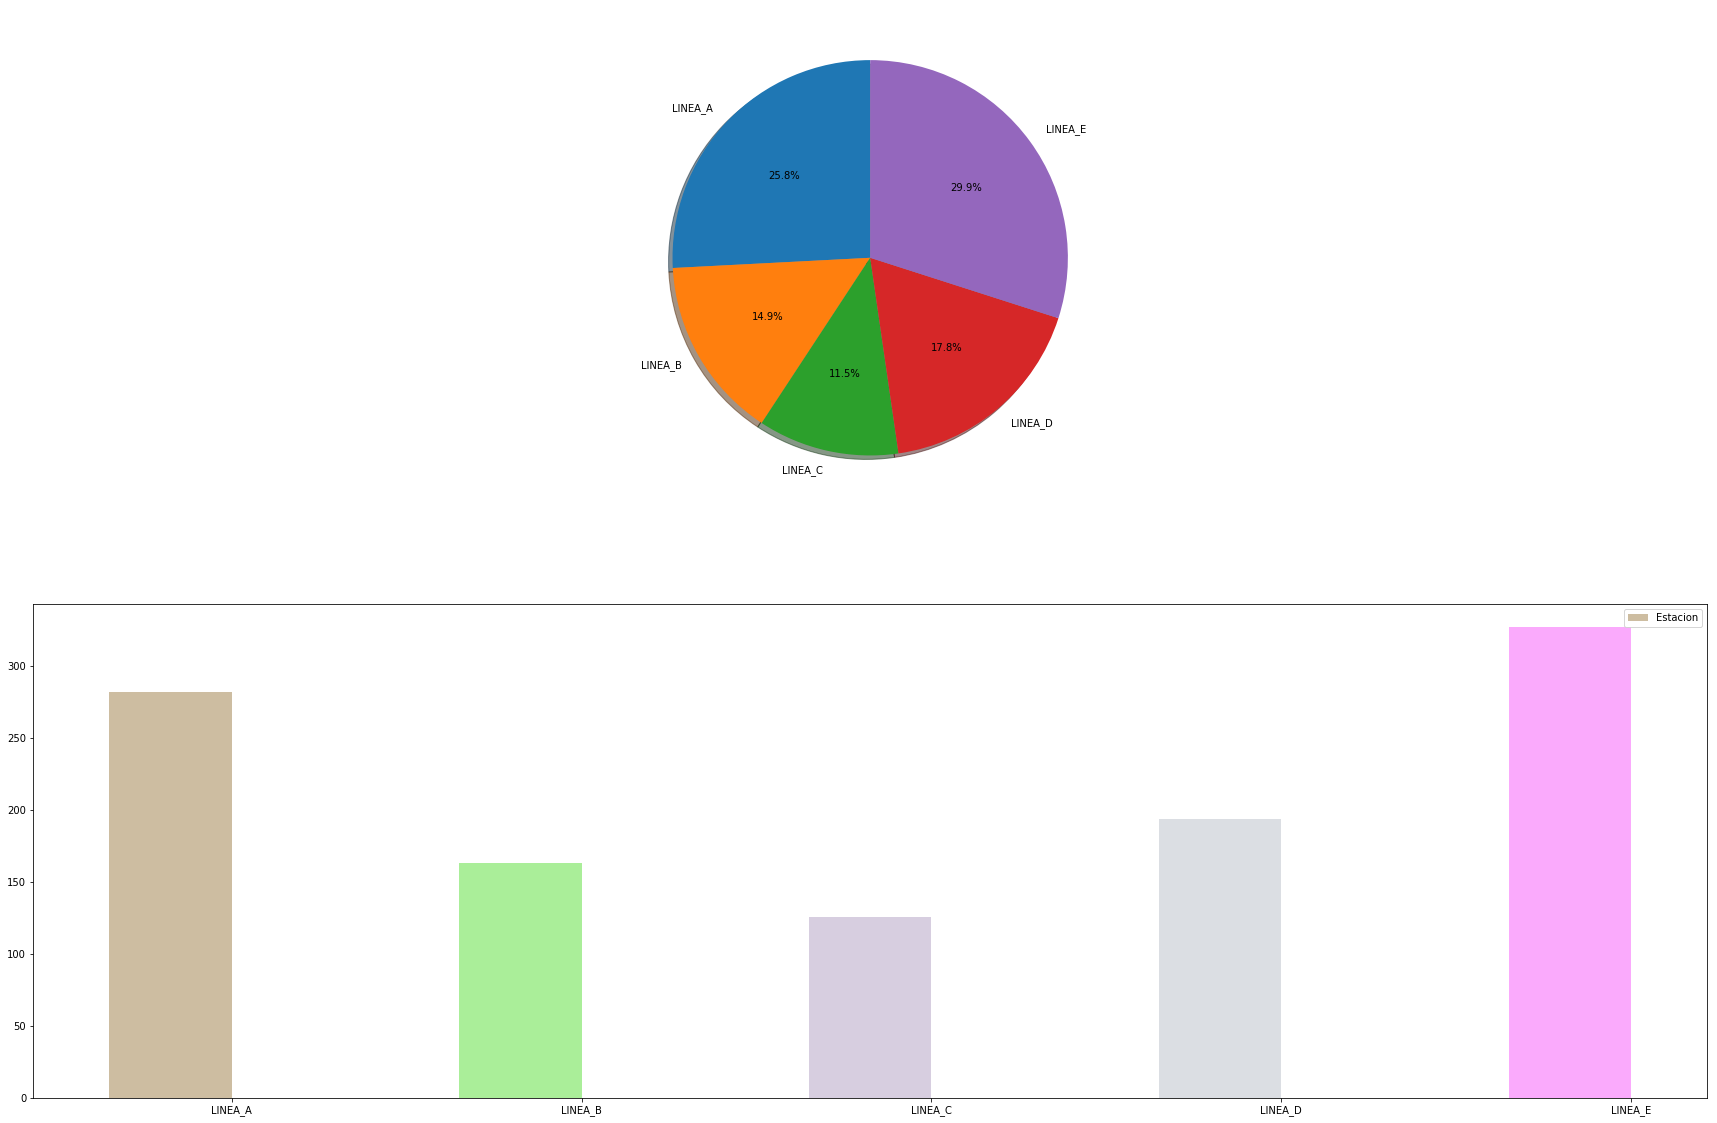

In [14]:
labels = twitttot.LINEA
sizes = twitttot.Issuetype
#explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

#bar chart
index = np.arange(twitttot.LINEA.count())
bar_width = 0.35
opacity = 0.4



fig, axs = plt.subplots(2, 1, figsize=(30,20))
axs[0].pie(sizes,  labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)                     
axs[1].bar(index, twitttot.Issuetype, bar_width,
                alpha=opacity, color=np.random.rand ( 256,3),
                label='Estacion')
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels(twitttot.LINEA)
axs[1].legend()


#fig.tight_layout()

plt.show()

Grafico problemas de las lineas por linea

In [15]:
twitttot=twitt.groupby(['LINEA','Month'], as_index=False)['Issuetype'].sum()

twitttotA=twitttot[twitttot.LINEA=='LINEA_A']
twitttotB=twitttot[twitttot.LINEA=='LINEA_B']
twitttotC=twitttot[twitttot.LINEA=='LINEA_C']
twitttotD=twitttot[twitttot.LINEA=='LINEA_D']
twitttotE=twitttot[twitttot.LINEA=='LINEA_E']
twitttotH=twitttot[twitttot.LINEA=='LINEA_H']

data1 = [go.Scatter(x=twitttotA.Month,y=twitttotA.Issuetype,mode ='lines+markers',
                   name="LineaA",
                   text=""),
         go.Scatter(x=twitttotB.Month,y=twitttotB.Issuetype,mode ='lines+markers',
                   name="LineaB",
                   text=""),
         go.Scatter(x=twitttotC.Month,y=twitttotC.Issuetype,mode ='lines+markers',
                   name="LineaC",
                   text=""),
         go.Scatter(x=twitttotD.Month,y=twitttotD.Issuetype,mode ='lines+markers',
                   name="LineaD",
                   text=""),
         go.Scatter(x=twitttotE.Month,y=twitttotE.Issuetype,mode ='lines+markers',
                   name="LineaE",
                   text=""),
         go.Scatter(x=twitttotH.Month,y=twitttotH.Issuetype,mode ='lines+markers',
                   name="LineaH",
                   text="")]


#data2 = go.Scatter(x=sdf.DESDE,y=sdf['MEAN'].apply(np.round),name="MEAN")

layout = dict(title = 'Problemas por mes 2018',
              xaxis = dict(title = 'Mes',dtick=1),
              yaxis = dict(title = 'Cantidad de problemas')
              )

fig = dict(data=data1,layout=layout)


py.iplot(fig)

Aw, snap! We didn't get a username with your request.

Don't have an account? https://plot.ly/api_signup

Questions? accounts@plot.ly


PlotlyError: Because you didn't supply a 'file_id' in the call, we're assuming you're trying to snag a figure from a url. You supplied the url, '', we expected it to start with 'https://plot.ly'.
Run help on this function for more information.

In [ ]:
#Hacer Eventos para slides

In [26]:
eventos = pd.read_csv(r'Todaslineas.csv', sep=";")


In [20]:
eventos.head()

,Unnamed: 0,PERIODO,FECHA,DESDE,HASTA,LINEA,MOLINETE,ESTACION,TOTAL,Month,Year
0,0,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_CBARROS_S_TURN01,CASTRO BARROS,1.000000,1,2018
1,1,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_LIMA_S_TURN03,LIMA,4.000000,1,2018
2,2,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_PASCO_TURN01,PASCO,1.000000,1,2018
3,3,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_PERU_S_TURN01,PERU,4.000000,1,2018
4,4,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_PJUNTA_S_TURN02,PRIMERA JUNTA,2.000000,1,2018


In [27]:
eventos=eventos[eventos['LINEA'].apply(lambda x: "LINEA_A" in x )]

,Unnamed: 0,PERIODO,FECHA,DESDE,HASTA,LINEA,MOLINETE,ESTACION,TOTAL,Month,Year
0,0,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_CBARROS_S_TURN01,CASTRO BARROS,1.000000,1,2018
1,1,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_LIMA_S_TURN03,LIMA,4.000000,1,2018
2,2,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_PASCO_TURN01,PASCO,1.000000,1,2018
3,3,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_PERU_S_TURN01,PERU,4.000000,1,2018
4,4,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_PJUNTA_S_TURN02,PRIMERA JUNTA,2.000000,1,2018
5,5,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_SANPEDRITO_OESTE_TURN03,SAN PEDRITO,1.000000,1,2018
32,32,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_CARABOBO_E_TURN03,CARABOBO,3.000000,1,2018
33,33,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_CARABOBO_E_TURN04,CARABOBO,2.000000,1,2018
34,34,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_CBARROS_N_TURN01,CASTRO BARROS,1.000000,1,2018


In [65]:
Abril = pd.read_csv(r'C:\Users\javier.gamboa\Desktop\Final-Project-EANT-master\Final-Project-EANT-master\Final-Project-EANT-master\Todaslineas.csv', sep=";")

In [66]:
Abril.head()

,Unnamed: 0,PERIODO,FECHA,DESDE,HASTA,LINEA,MOLINETE,ESTACION,TOTAL,Month,Year
0,0,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_CBARROS_S_TURN01,CASTRO BARROS,1.000000,1,2018
1,1,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_LIMA_S_TURN03,LIMA,4.000000,1,2018
2,2,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_PASCO_TURN01,PASCO,1.000000,1,2018
3,3,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_PERU_S_TURN01,PERU,4.000000,1,2018
4,4,201801,2018-01-01,08:00:00,08:15:00,LINEA_A,LINEA_A_PJUNTA_S_TURN02,PRIMERA JUNTA,2.000000,1,2018


In [91]:
Abril2=Abril.groupby(['LINEA','Month','FECHA'], as_index=False)['TOTAL'].sum()

In [92]:
Abril2=Abril2[Abril2.LINEA=='LINEA_A']

In [93]:
Abril2

,LINEA,Month,FECHA,TOTAL
0,LINEA_A,1,2018-01-01,"18,220.000000"
1,LINEA_A,1,2018-01-02,"194,042.000000"
2,LINEA_A,1,2018-01-03,"221,113.000000"
3,LINEA_A,1,2018-01-05,"35,603.000000"
4,LINEA_A,1,2018-01-06,"252,866.000000"
5,LINEA_A,1,2018-01-08,"234,411.000000"
6,LINEA_A,1,2018-01-10,"238,935.000000"
7,LINEA_A,1,2018-01-11,"185,777.000000"
8,LINEA_A,1,2018-01-12,"176,449.000000"
9,LINEA_A,1,2018-01-13,"66,512.000000"


In [97]:
# Python program to Find day of  
# the week for a given date 
import datetime 
import calendar 

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import plotly.plotly as ply
import plotly.graph_objs as go
from datetime import datetime
import numpy as np




In [100]:
#creates column with weekday name
#https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
#https://webcache.googleusercontent.com/search?q=cache:GywFzb4hhjsJ:https://stackoverflow.com/questions/8380389/how-to-get-day-name-in-datetime-in-python+&cd=1&hl=es-419&ct=clnk&gl=ar

Abril2['FECHA'] = pd.to_datetime(pd.Series(Abril2['FECHA']), format="%Y/%m/%d")



In [101]:
Abril2['WeekDay'] = Abril2['FECHA'].dt.strftime("%A")

In [102]:
Abril2.head()

,LINEA,Month,FECHA,TOTAL,WeekDay
0,LINEA_A,1,2018-01-01,"18,220.000000",Monday
1,LINEA_A,1,2018-01-02,"194,042.000000",Tuesday
2,LINEA_A,1,2018-01-03,"221,113.000000",Wednesday
3,LINEA_A,1,2018-01-05,"35,603.000000",Friday
4,LINEA_A,1,2018-01-06,"252,866.000000",Saturday


In [137]:
Abril2=Abril2[Abril2.Month==4]

In [138]:
Abril2.head()

,LINEA,Month,FECHA,TOTAL,WeekDay
81,LINEA_A,4,2018-04-01,"224,318.000000",Sunday
82,LINEA_A,4,2018-04-02,"79,791.000000",Monday
83,LINEA_A,4,2018-04-03,"285,982.000000",Tuesday
84,LINEA_A,4,2018-04-04,"252,488.000000",Wednesday
85,LINEA_A,4,2018-04-05,"516,847.000000",Thursday


In [142]:
Abril2= Abril2[Abril2.WeekDay=='Tuesday']

In [143]:
Abril2

,LINEA,Month,FECHA,TOTAL,WeekDay
83,LINEA_A,4,2018-04-03,"285,982.000000",Tuesday
90,LINEA_A,4,2018-04-10,"523,005.000000",Tuesday
97,LINEA_A,4,2018-04-17,"234,266.000000",Tuesday
104,LINEA_A,4,2018-04-24,"263,869.000000",Tuesday


In [144]:
#mean and std by weekday

#https://webcache.googleusercontent.com/search?q=cache:iBCzF1giI64J:https://stackoverflow.com/questions/30482071/how-to-calculate-mean-values-grouped-on-another-column-in-pandas+&cd=1&hl=es-419&ct=clnk&gl=ar
AbrilTotalmean = Abril2.groupby('WeekDay', as_index=False)['TOTAL'].mean()

#https://webcache.googleusercontent.com/search?q=cache:cHr8bCdXsYUJ:https://stackoverflow.com/questions/20350863/pandas-dataframe-groupby-std+&cd=1&hl=es-419&ct=clnk&gl=ar
AbrilTotalstd = Abril2.groupby('WeekDay')['TOTAL'].std()


#Debate Aborto 10 de Abril, graficar cada martes de Abril y mean & STD

In [173]:
Xmes = pd.read_csv(r'C:\Users\javier.gamboa\Desktop\Final-Project-EANT-master\Final-Project-EANT-master\Final-Project-EANT-master\Todaslineas.csv', sep=";")

In [174]:
Xmes=Xmes.groupby(['LINEA','Month','FECHA'], as_index=False)['TOTAL'].sum()

Xmes=Xmes[Xmes.LINEA=='LINEA_A']

In [175]:
Xmes['FECHA'] = pd.to_datetime(pd.Series(Xmes['FECHA']), format="%Y/%m/%d")


In [176]:
Xmes['WeekDay'] = Xmes['FECHA'].dt.strftime("%A")

In [181]:
#Feriado 12 de Octubre

Octubre1=Xmes[Xmes.WeekDay=='Friday']


In [179]:
Octubre2= Xmes[Xmes.Month==10] 


In [182]:
OctubreTotalmean = Octubre1.groupby('WeekDay', as_index=False)['TOTAL'].mean()

#https://webcache.googleusercontent.com/search?q=cache:cHr8bCdXsYUJ:https://stackoverflow.com/questions/20350863/pandas-dataframe-groupby-std+&cd=1&hl=es-419&ct=clnk&gl=ar
OctubreTotalstd = Octubre1.groupby('WeekDay')['TOTAL'].std()


,LINEA,Month,FECHA,TOTAL,WeekDay
3,LINEA_A,1,2018-01-05,"35,603.000000",Friday
8,LINEA_A,1,2018-01-12,"176,449.000000",Friday
15,LINEA_A,1,2018-01-19,"182,727.000000",Friday
22,LINEA_A,1,2018-01-26,"179,794.000000",Friday
29,LINEA_A,2,2018-02-02,"193,292.000000",Friday
40,LINEA_A,2,2018-02-16,"205,916.000000",Friday
47,LINEA_A,2,2018-02-23,"212,954.000000",Friday
54,LINEA_A,3,2018-03-02,"75,324.000000",Friday
65,LINEA_A,3,2018-03-16,"242,127.000000",Friday
72,LINEA_A,3,2018-03-23,"244,723.000000",Friday


In [183]:
#G20 30 de Noviembre
Novi1=Xmes[Xmes.WeekDay=='Friday']
Novi2= Xmes[Xmes.Month==11] 
Novi2

,LINEA,Month,FECHA,TOTAL,WeekDay
283,LINEA_A,11,2018-11-01,"246,095.000000",Thursday
284,LINEA_A,11,2018-11-02,"239,153.000000",Friday
285,LINEA_A,11,2018-11-03,"100,884.000000",Saturday
286,LINEA_A,11,2018-11-04,"48,702.000000",Sunday
287,LINEA_A,11,2018-11-05,"236,650.000000",Monday
288,LINEA_A,11,2018-11-06,"230,247.000000",Tuesday
289,LINEA_A,11,2018-11-07,"251,055.000000",Wednesday
290,LINEA_A,11,2018-11-08,"247,575.000000",Thursday
291,LINEA_A,11,2018-11-09,"246,490.000000",Friday
292,LINEA_A,11,2018-11-10,"54,107.000000",Saturday


In [184]:
NoviTotalmean = Novi1.groupby('WeekDay', as_index=False)['TOTAL'].mean()

#https://webcache.googleusercontent.com/search?q=cache:cHr8bCdXsYUJ:https://stackoverflow.com/questions/20350863/pandas-dataframe-groupby-std+&cd=1&hl=es-419&ct=clnk&gl=ar
NoviTotalstd = Novi1.groupby('WeekDay')['TOTAL'].std()